# Projeto 2 - Ciência dos Dados

##### Faculdade: Insper - Instituto de Ensino e Pesquisa

**Nome**: Jonas da Silva Lopes

**Nome**: William Augusto Reis da Silva

**Turma**: Engenharia | 2A


# Classificador automático de sentimento

Este projeto consiste na análise de dados de tweets, por meio da biblioteca tweepy, para realizar um classificador de sentimento, demonstrando se um tweety é relevante ou irrelevante. Para isso, realizamos algumas funções para que possamos determinar esta análise.

## Preparando o ambiente no jupyter:

Importando e instalando as bibliotecas

In [1]:
%%capture
!pip install tweepy
!pip install emoji

In [2]:
import tweepy
import emoji
import math
import os.path
import pandas as pd
import json
import re 
import functools
import operator
from random import shuffle

___
## Autenticando no  Twitter

* Conta utilizada: ***@William48253649***

In [3]:
# Identificador da conta no twitter: @William48253649

# Leitura do arquivo no formato JSON
with open('auth.pass') as fp:    
    data = json.load(fp)

# Configurando a biblioteca
auth = tweepy.OAuthHandler(data['consumer_key'], data['consumer_secret'])
auth.set_access_token(data['access_token'], data['access_token_secret'])

___
## Etapas do projeto:

### Escolha de um produto e coleta das mensagens


O produto escolhido para a análise será a empresa Nubank, tendo em vista que é uma empresa em alta e que possui, possivelmente, diversas opiniões no Twitter

In [6]:
#Produto escolhido
produto = 'Nubank'

#Quantidade mínima de mensagens capturadas
n = 500
#Quantidade mínima de mensagens para a base de treinamento
t = 300

#Filtro de língua
lang = 'pt'

Capturando os dados do twitter:

In [7]:
# Cria um objeto para a captura
api = tweepy.API(auth)

# Inicia a captura
i = 1
msgs = []
for msg in tweepy.Cursor(api.search, q=produto, lang=lang, tweet_mode="extended").items():    
    msgs.append(msg.full_text.lower()) # Lower para deixar tudo minúsculo e facilitar a comparação
    i += 1
    if i > n:
        break

# Embaralhando as mensagens para reduzir um possível viés
shuffle(msgs)

Salvando os dados em uma planilha Excel:

In [8]:
# Verifica se o arquivo não existe para não substituir um conjunto pronto
if not os.path.isfile('./{0}.xlsx'.format(produto)):
    
    # Abre o arquivo para escrita
    writer = pd.ExcelWriter('{0}.xlsx'.format(produto))

    # Divide o conjunto de mensagens em duas planilhas
    # Planilha de treinamento
    dft = pd.DataFrame({'Treinamento' : pd.Series(msgs[:t])}).set()
    dft.to_excel(excel_writer = writer, sheet_name = 'Treinamento', index = False)

    # Planilha de teste
    dfc = pd.DataFrame({'Teste' : pd.Series(msgs[t:])}).set()
    dfc.to_excel(excel_writer = writer, sheet_name = 'Teste', index = False)

    # Fecha o arquivo
    writer.save()

___
### Classificando as mensagens na coragem

Após realizar a classificação manual das mensagens, como irrelevante (0) ou relevante (1), partimos para  a mudança desses valores para algo mais palpável para a análise. Com isso, fazemos a alteração que pode ser vista abaixo.

Mas, para realizar isso, primeiro foi necessário determinar critérios para a classificação:

- Mencionar o produto;
- A menção ao produto deve ser acompanhada de uma opinião;
- A opinião pode ser demonstrada na forma de indagações, reclamações, pode envolver sarcasmo, elogios e sugestões sobre serviços;
- A opinião afirmada deve ser clara;
- Emoctions também representam opiniões.

In [163]:
# Lendo o arquivo Nubank
mensagens = pd.read_excel("Nubank.xlsx")
mensagens.Relevância = mensagens.Relevância.astype('category')
mensagens.Relevância.cat.categories = ('Irrelevante', 'Relevante')

# Separando em relevante e irrelevante
relevante = mensagens[mensagens.Relevância=="Relevante"]
irrelevante = mensagens[mensagens.Relevância=="Irrelevante"]

# Soma da quantidade de palavras
total = len(relevante) + len(irrelevante)

print("A quantidade de cada cada um é: \n\n", mensagens.Relevância.value_counts())

A quantidade de cada cada um é: 

 Irrelevante    184
Relevante      116
Name: Relevância, dtype: int64


In [10]:
'''A Partir dos dados obtidos, nota-se que:
        p(relevante) = 116/300
        p(irrelevante) = 184/300
'''
p_relev = 116/300*100
print("A probabilidade de ser relevante é", p_relev, "%")

p_irrelev = 184/300*100
print("A probabilidade de ser irrelevante é", p_irrelev, "%")

A probabilidade de ser relevante é 38.666666666666664 %
A probabilidade de ser irrelevante é 61.33333333333333 %


#### Limpeza das mensagens

In [11]:
''' Função que troca pontuação por espaço '''
def cleanup(text):
    punctuation = '[!\-.:?;/,|@"\'()]'
    pattern = re.compile(punctuation)
    # Abaixo, determina que se troca por espaço
    text_subbed = re.sub(pattern, ' ', text)
    
    emoji_dividir = emoji.get_emoji_regexp().split(text_subbed)
    espaco_dividir = [substr.split() for substr in emoji_dividir]
    split = functools.reduce(operator.concat, espaco_dividir)
    
    return split

# Usando a função apply para fazer a limpeza nas mensagens
nubank_relev = relevante.Treinamento.apply(cleanup)
nubank_irrelev = irrelevante.Treinamento.apply(cleanup)

# Pegando as palavras da lista para contar
def pega_text(texto):
    # Pega as palavras para colocar numa lista
    lista = []
    i = 0
    for linha in texto:
        if len(linha) > 1:
            while i < len(linha):
                lista.append(linha[i])
                i += 1  
            i = 0
        elif len(linha) != 1 and (len(linha)-1) != 1:
            a = texto
            return a 
    return lista # Retorna a lista com as palavras separadas

### Frequência Absoluta

Abaixo, temos a análise das frequências das palavras, sendo relevantes e irrelevantes, mostrando as que mais aparecem.

##### Relevantes

In [171]:
# Frequência dos Relevantes
lista_nubank_relev = pd.DataFrame(pega_text(nubank_relev))

lista_nubank_relev[0].value_counts().head()

nubank    122
o          58
de         54
e          52
eu         47
Name: 0, dtype: int64

##### Irrelevantes

In [170]:
# Frequência dos Irrelevantes
lista_nubank_irrelev = pd.DataFrame(pega_text(nubank_irrelev))

lista_nubank_irrelev[0].value_counts().head()

nubank    154
o          71
de         67
e          62
que        60
Name: 0, dtype: int64

### Frequência Relativa

##### Relevante

In [168]:
lista_nubank_relev[0].value_counts(True).head()

nubank    0.056092
o         0.026667
de        0.024828
e         0.023908
eu        0.021609
Name: 0, dtype: float64

##### Irrelevante

In [169]:
lista_nubank_irrelev[0].value_counts(True).head()

nubank    0.045441
o         0.020950
de        0.019770
e         0.018294
que       0.017704
Name: 0, dtype: float64

___
### Montando o Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, estamos ensinando nosso treinador a identificar as probabilidades, para posteriormente fazer a identificação e a leitura. 

#### Relevantes

In [177]:
'''Fazendo dicionários, para serem utilizados com objetivos na função'''

# Limpa uma das linhas da mensagem
linhas_mens = mensagens.Treinamento.apply(cleanup)[0]

# Dicionário que guarda, dos relevantes, as palavras e quantas vezes apareceu
lista_counts_relevante = (lista_nubank_relev[0].value_counts()).to_dict()

# Dicionário que guarda a quantidade de relevantes e irrelevantes
dicionario_counts_relevancia = (mensagens.Relevância.value_counts()).to_dict()

Abaixo, temos a função que será usada para o cálculo da frase de ser relevante

In [178]:
# Função que calcula as probabilidade de ser relevante
def probabilidade_do_naive(lista_counts_relevante, dicionario_counts_relevancia, total, linhas_mens, lista_nubank_relev):
    verossimilhança = 1
    for word in linhas_mens:
        for key, values in lista_counts_relevante.items():
            if key == word:
                verossimilhança *= (values+1)/(len(lista_nubank_relev)+len(linhas_mens))
    
    for rel, v in dicionario_counts_relevancia.items():
        if rel == "Relevante":
            total_rel = v
    priori = total_rel/total
    
    return (('{0:.2f}').format(math.log10(verossimilhança * priori)))

#print(probabilidade_do_naive(lista_counts_relevante, dicionario_counts_relevancia, total, linhas_mens, lista_nubank_relev))

#### Irrelevantes

Abaixo, a função que calcula a probabilidade de ser irrelevante

In [179]:
# Dicionário que guarda, dos irrelevantes, as palavras e quantas vezes apareceu
lista_counts_irrelevante = (lista_nubank_irrelev[0].value_counts()).to_dict()

# Função que calcula as probabilidade de ser irrelevante
def probabilidade_do_naive_irr(lista_counts_irrelevante, dicionario_counts_relevancia, total, linhas_mens, lista_nubank_irrelev):
    verossimilhança = 1
    # Identificando a quantidade e calculando a probabilidade de cada palavra do tweet
    for word in linhas_mens:
        for key, values in lista_counts_irrelevante.items():
            if key == word:
                verossimilhança *= (values+1) / (len(lista_nubank_irrelev)+len(linhas_mens))
    
    # Pegando a probabilidade e dividindo pelo total, usando Naive Bayes
    for rel, v in dicionario_counts_relevancia.items():
        if rel == "Irrelevante":
            total_rel = v
    priori = total_rel/total
    
    return (('{0:.2f}').format(math.log10(verossimilhança * priori)))

As funções foram criadas no treinamento com o intuito de serem utilizadas na verificação da perfomance, que será realizada abaixo

___
### Verificando a performance

A partir do treinamento, iremos usar tal realização para verificar a perfomance do nosso dispositivo

In [194]:
# Leitura dos arquivos
df_teste = pd.ExcelFile("Nubank.xlsx")
df_teste1 = pd.read_excel(df_teste, 'Teste')

#### Criando os argumentos que entraram na função criada

Número de tweets relevantes e irrelevantes e seu total

In [181]:
df_teste1.Relevância = mensagens.Relevância.astype('category')
df_teste1.Relevância.cat.categories = ('Irrelevante', 'Relevante')

relevante_teste = df_teste1[df_teste1.Relevância=="Relevante"]
irrelevante_teste = df_teste1[df_teste1.Relevância=="Irrelevante"]

total_teste = len(relevante_teste) + len(irrelevante_teste)

print("A quantidade de cada cada um é: \n\n", df_teste1.Relevância.value_counts())
dicionario_counts_relevância1 = (df_teste1.Relevância.value_counts()).to_dict()
dicionario_counts_relevância1

A quantidade de cada cada um é: 

 Irrelevante    121
Relevante       79
Name: Relevância, dtype: int64


{'Irrelevante': 121, 'Relevante': 79}

#### Relevante

Frequência absoluta das palavras nos tweets relevantes e transformando em dicionário

In [182]:
# Usando a função apply para fazer a limpeza nas mensagens
df_teste2_rel = relevante_teste.Teste.apply(cleanup)
df_teste2_rel = pd.DataFrame(pega_text(df_teste2_rel))

# Criando dicionário
dict_teste_counts_rel = (df_teste2_rel[0].value_counts()).to_dict()
total_teste_rel = df_teste2_rel

#### Irrelevante

Frequência absoluta das palavras nos tweets irrelevantes e tranformando em dicionário

In [196]:
df_teste2_irrel = pd.DataFrame(pega_text(irrelevante_teste.Teste.apply(cleanup)))
dict_teste_counts_irrel = (df_teste2_irrel[0].value_counts()).to_dict()
total_teste_irrel = df_teste2_irrel


In [197]:
linhas_mens_teste = df_teste1.Teste.apply(cleanup)[0]

In [198]:
# Exemplo de funcionamento
print(probabilidade_do_naive_irr(dict_teste_counts_rel, dicionario_counts_relevância1, total, linhas_mens_teste, total_teste_rel))

-9.76


#### Relevante

Cálculo da probabilidade de ser relevante, com base na planilha Teste, para fazer o teste

In [199]:
probs_relevante2 = [0]*200

i = 0
for elemento in probs_relevante2:
    linhas_mens_teste = df_teste1.Teste.apply(cleanup)[i]
    probs_relevante2[i] = probabilidade_do_naive(dict_teste_counts_rel, dicionario_counts_relevância1, total_teste, linhas_mens_teste, df_teste2_rel)
    i += 1



#### Irrelevante

Abaixo, calculando a probabilidade de ser irrelevante, com base no ensinamento e treinamento da máquina

In [200]:
probs_irrelevante2 = [0]*200

i = 0
for elemento in probs_irrelevante2:
    linhas_mens_teste = df_teste1.Teste.apply(cleanup)[i]
    probs_irrelevante2[i] = probabilidade_do_naive_irr(dict_teste_counts_irrel, dicionario_counts_relevância1, total_teste, linhas_mens_teste, df_teste2_irrel)
    i += 1

#### Comparação

In [201]:
def comparation(relevante, irrelevante):
    i = 0 
    result = []
    for e in relevante:
        if relevante[i] > irrelevante[i]:
            result.append("Relevante")
        elif relevante[i] < irrelevante[i]:
            result.append("Irrelevante")
        # É muito improvável que ocorra. Porém, se ocorrer, consideramos que é irrelevante
        else:
            result.append(0)
        i += 1    
        
    return result

In [189]:
resultado_das_relevancias = comparation(probs_relevante2, probs_irrelevante2)

In [190]:
serie = []
for linha in df_teste1.Relevância:
    serie.append(linha)

def comparação_com_classificados(relevancias_comparativas, classificados):
    i = 0 
    true = 0
    false = 0
    comparação_final = []
    for e in classificados:
        if relevancias_comparativas[i] == classificados[i]:
            comparação_final.append(True)
            true += 1
        else:
            comparação_final.append(False)
            false += 1
        i+=1
            
    print(f'True: {true}, False: {false}')    
    
    return comparação_final, true, false

result, exito, fracasso = comparação_com_classificados(resultado_das_relevancias, serie)

True: 160, False: 40


In [191]:
def porcentagem(serie, resultado_das_relevancias):
    i = 0
    soma = 0
    ver_pos = 0
    fal_pos = 0
    ver_neg = 0
    fal_neg = 0
    
    for elemento in serie:
        if serie[i] == "Relevante" and resultado_das_relevancias[i]== "Relevante":
            ver_pos += 1
        elif serie[i] == "Irrelevante" and resultado_das_relevancias[i]== "Irrelevante":
            ver_neg += 1
        elif serie[i] == "Relevante" and resultado_das_relevancias[i]== "Irrelevante":
            fal_neg += 1
        elif serie[i] == "Irrelevante" and resultado_das_relevancias[i]== "Relevante":
            fal_pos += 1
        soma += 1
        i += 1
            
    return ver_pos/soma, ver_neg/soma, fal_pos/soma, fal_neg/soma

lista_porcentagem = porcentagem(serie, resultado_das_relevancias)
list_porc = []
i = 0
for e in lista_porcentagem:
    e *= 100
    list_porc.append(e)
    i += 1
    
    
print(f'Verdadeiros positivos: {list_porc[0]}%')
print(f'Falsos positivos: {list_porc[2]}%')
print(f'Verdadeiros negativos: {list_porc[1]}%')
print(f'Falsos negativos: {list_porc[3]}%')

Verdadeiros positivos: 32.0%
Falsos positivos: 12.5%
Verdadeiros negativos: 48.0%
Falsos negativos: 7.5%


## Concluindo

### Análise da eficiência do classificador Naive-Bayes

O classificador teve um bom desempenho em classificar os tweets segundo os critérios pré selecionados e que definiam em qual categoria um tweet seria agrupado, tendo em vista que 80% de todos os tweets testes foram classificados corretamente, ou seja, 80% dos tweets foram classificados como verdadeiros positivos ou verdadeiros negativos.

Text(0.5, 1.0, 'Gráfico da quantidade de êxitos do classificador(em %)')

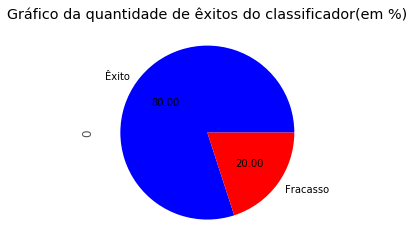

In [192]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

dici_pizza = {'Êxito':[exito], 'Fracasso':[fracasso]}
grafico_pizza = pd.DataFrame(dici_pizza).transpose()
grafico_pizza.plot(kind='pie', colors=('blue', 'red'), autopct="%0.2f",legend=False, subplots=True)
plt.title('Gráfico da quantidade de êxitos do classificador(em %)')

Text(0.5, 1.0, 'Relação entre as possíveis contagens(em %)')

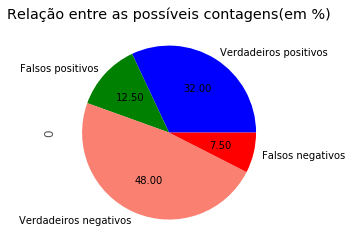

In [193]:
grafico_pizza2 = pd.DataFrame({'Verdadeiros positivos': [list_porc[0]], 'Falsos positivos': [list_porc[2]], 'Verdadeiros negativos': [list_porc[1]], 'Falsos negativos': [list_porc[3]]}).transpose()
grafico_pizza2.plot(kind='pie', colors=('blue', 'green', 'salmon', 'red'), autopct="%0.2f",legend=False, subplots=True)
plt.title('Relação entre as possíveis contagens(em %)')

### Mensagens de dupla negação e sarcasmo

As mensagens de dupla negação e sarcasmo não possuem interferência no nosso classificador, pois os critérios adotados não abrangem as características de que se uma opinião é boa ou ruim e sim se o tweety representa uma opinião clara ou não. 

### Plano de expansão

Primeiramente, o projeto teve resultados positivos, pois cerca de 80% dos tweets foram classificados corretamente, ou seja, o feedback dos investimentos aplicados pela empresa tem sido positivos. Além disso, possui-se um plano de expansão que envolve a categorização dos tweets relevantes em opiniões boas ou ruins a respeito do produto, tornando assim a probabilidade como uma ferramenta a favor do marketing da companhia.

### Limpezas e transformações nos tweets

Para uma melhor limpeza dos tweets e a fim de aumentar a eficiência do classificador, pensa-se em retirar palavras que geralmente não ajudam a emitir opiniões, ou não as modifiquem quando retiradas, como artigos e alguns adjuntos adverbiais, ou seja utilizando o método Removing StopWords, como apontado pelo artigo do site monkeylearn.com.

### Por que não usar o próprio classificador para gerar mais análises?

O classificador foi projetado em um modelo em que ele tem a capacidade de analsiar somente duas categorias. Além disso, critérios específicos e subjetivos foram estabelecidos a fim de fe

### Diferentes fenômenos que podem ser aplicados

O ideal realizado nesse projeto é de extrema relevância no mundo da Ciência dos Dados e pode ser utilizado em diversos contextos, desde identificação de mensagens de spam, que possuem semelhantes tipos de palavras com o objetivo de enganar em e-mails. Ademais, pode ser usado em análise de usuários, sobre o que eles escrevem e como podemos identificar seus padrões de palavras e postagens para colocar anúncios dirigidos a eles.

# Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**